# Sequential Probability Ratio Test (SPRT)

## Import libraries

In [3]:
#!pip install statsmodels matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize
from statsmodels.stats.power import NormalIndPower

## Importing data

In [4]:
df = pd.read_csv('SPRT_homework_1.csv')

In [5]:
df

,cont_conv_A,cont_conv_B
0,0,0
1,0,0
2,1,0
3,1,0
4,0,0
...,...,...
21253,0,0
21254,0,0
21255,0,0
21256,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21258 entries, 0 to 21257
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   cont_conv_A  21258 non-null  int64
 1   cont_conv_B  21258 non-null  int64
dtypes: int64(2)
memory usage: 332.3 KB


In [7]:
df.cont_conv_A.mean()

0.17061812023708722

In [8]:
df.cont_conv_B.mean()

0.1789443974033305

## Tasks

### Task 1.

 **Find p-value for z-proportions test.**

In [9]:
count = [df.cont_conv_A.sum(), df.cont_conv_B.sum()]
nobs = [df.shape[0], df.shape[0]]


proportions_ztest(count, nobs, alternative='two-sided')

(-2.2602948445808004, 0.023802957738736988)

### Task 2.  

**What result will be gained using SPRT technique?** 

In [10]:
def get_decision_list_sprt_binom(values_A, values_B, alpha = 0.05, beta = 0.2, mde = 0.1):
    '''Function for conducting SPRT analysis for proportions (shares, conversions)
    values_A - A list of conversion values in group A (0, 1)
    values_B - A list of conversion values in group B (0, 1)
    alpha - The significance level of the SPRT test
    beta - The type II error rate of the SPRT test
    mde - The minimum detectable effect (MDE) of the SPRT test
    
    return
    - early_stop_index: The index at which the SPRT test stopped and made a decision. 
        If the SPRT test was unable to make a decision after all observations, len(data) is returned
    - inference: The hypothesis that was accepted by the SPRT test
    - left_bound_list: A list of boundaries for making a decision. 
        The length of this list is early_stop_index
    - right_bound_list:A list of boundaries for making a decision. 
        The length of this list is early_stop_index.
    - S_list: A list of calculated values reflecting the change in the dynamics of the difference in proportions. 
        The length of this list is early_stop_index.
    - cum_diff_list: A list of cumulative increasing difference between the proportions in two groups. 
        The length of this list is early_stop_index.    
    '''
    min_len = int(np.mean([len(values_A), len(values_B)]))
    A = math.log(beta/(1 - alpha))
    B = math.log((1 - beta)/alpha)
    p = (values_A.mean() + values_B.mean())/2
    
    left_bound_list = []
    right_bound_list = []
    S_list = []
    cum_diff_list = []
    
    for i in range(100, min_len):
        p0_i = np.mean(values_A[0:i])
        p1_i = np.mean(values_B[0:i])
        
        disp = p * (1 - p)
        diff = p1_i - p0_i
        left_bound = 2 * disp * A / mde
        right_bound = 2 * disp *  B / mde
        
        S = (i + 1) * (diff - mde/2)
        
        left_bound_list.append(left_bound)
        right_bound_list.append(right_bound)
        S_list.append(S)
        cum_diff_list.append(diff)
        
        if S < left_bound:
            return {'early_stop_index':i, 'inference':'Accept H0', 'left_bound_list': left_bound_list, 'right_bound_list': right_bound_list, 'S_list': S_list, 'cum_diff_list':cum_diff_list}
        if S > right_bound:
            return {'early_stop_index':i, 'inference':'Accept H1', 'left_bound_list': left_bound_list, 'right_bound_list': right_bound_list, 'S_list': S_list, 'cum_diff_list':cum_diff_list}
    return {'early_stop_index':i, 'inference':'Continue', 'left_bound_list': left_bound_list, 'right_bound_list': right_bound_list, 'S_list': S_list, 'cum_diff_list':cum_diff_list}

Result: Accept H1
Obervation # to draw the result: 15314


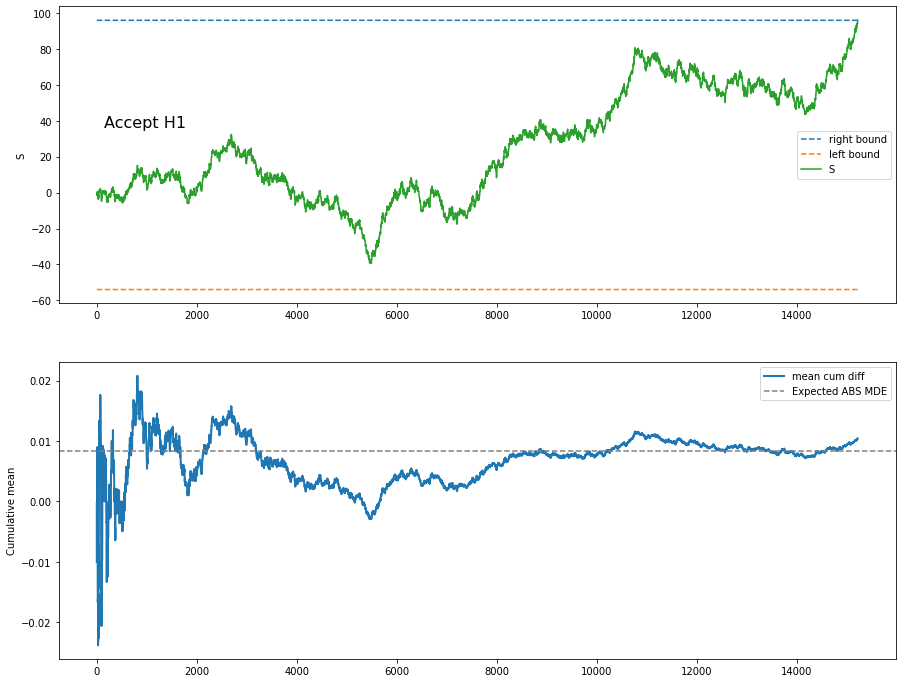

In [11]:
mde_abs = np.abs(df.cont_conv_A.mean() - df.cont_conv_B.mean())


inference_object = get_decision_list_sprt_binom(df.cont_conv_A, 
                                                df.cont_conv_B,
                                                alpha = 0.05, 
                                                beta = 0.2,
                                                mde = mde_abs)

print('Result:', inference_object['inference'])
print('Obervation # to draw the result:', inference_object['early_stop_index'])

fig, axes = plt.subplots(2, figsize=(15,12))

sns.lineplot(ax=axes[0], x = np.arange(1, len(inference_object['right_bound_list'])+1), y = inference_object['right_bound_list'], ls = '--', label='right bound')
sns.lineplot(ax=axes[0], x = np.arange(1, len(inference_object['left_bound_list'])+1), y = inference_object['left_bound_list'], ls = '--', label='left bound')
sns.lineplot(ax=axes[0], x = np.arange(1, len(inference_object['S_list'])+1), y = inference_object['S_list'], label='S')
axes[0].set_ylabel(ylabel = "S")
axes[0].text(y = np.quantile(inference_object['S_list'], 0.65), x = len(inference_object['S_list']) * 0.01, s = inference_object['inference'], fontsize = 16)
axes[0].legend()

sns.lineplot(ax=axes[1], x = np.arange(1, len(inference_object['right_bound_list'])+1), y = inference_object['cum_diff_list'], label='mean cum diff', linewidth=2)
axes[1].axhline(mde_abs, ls='--', color='gray', label = 'Expected ABS MDE')
axes[1].set_ylabel(ylabel = "Cumulative mean")
axes[1].legend();

### Task 3. 

**Find fixed horizon sample size to detect 0.05 relative effect on our data.** 

In [17]:
baseline_conversion = df.cont_conv_A.mean()
rel_mde = 0.05


d = proportion_effectsize(baseline_conversion * (1 + rel_mde), baseline_conversion)

n = NormalIndPower().solve_power(
                effect_size = d,
                power = 0.8,
                alpha = 0.05,
                nobs1 = None,
                ratio = 1
                )

print(np.ceil(n))

31121.0


### Task 4. 

**Find an avarage SPRT sample size for AA simulations.**

In [14]:
np.random.seed(2)

n = 31121
rel_mde = 0.05
sample_size_lst = []

n_iter = 300
for i in range(n_iter):
    values_A1 = np.random.choice(df['cont_conv_A'], n)
    values_A2 = np.random.choice(df['cont_conv_A'], n)
    values_B = np.random.choice(df['cont_conv_A'], n)

    inference_object = get_decision_list_sprt_binom(values_A1, 
                                                    values_A2,
                                                    alpha = 0.05, 
                                                    beta = 0.2,
                                                    mde = df['cont_conv_A'].mean() * rel_mde)

    sample_size_lst.append(inference_object['early_stop_index'])
    
print(int(np.mean(sample_size_lst)))

10696


### Task 5. 

**Find an avarage SPRT sample size for AB simulations.**

In [24]:
np.random.seed(2)

n = 31121
rel_mde = 0.05
mean_ = df['cont_conv_A'].mean()
abs_mde = mean_ * rel_mde
sample_size_lst = []

n_iter = 300
for i in range(n_iter):
    values_A1 = np.random.choice(df['cont_conv_A'], n)
    values_A2 = np.random.choice(df['cont_conv_A'], n)
    values_B = np.random.choice(df['cont_conv_B'], n)

    inference_object = get_decision_list_sprt_binom(values_A1, 
                                                    values_B,
                                                    alpha = 0.05, 
                                                    beta = 0.2,
                                                    mde = abs_mde)

    sample_size_lst.append(inference_object['early_stop_index'])
    
print(np.ceil(np.mean(sample_size_lst)))

14547.0


### Task 6. 

**Calculate power for SPRT A/B test.**

In [ ]:
tbc..